# 从零开始的自然语言处理: 通过字符级RNN网络进行人名的语种判别

[原始文章: NLP From Scratch: Classifying Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#nlp-from-scratch-classifying-names-with-a-character-level-rnn)

## 数据准备

In [1]:
from io import open
import glob
import pathlib
import os
import unicodedata
import string

In [2]:
from typing import List, Dict, Tuple, Any

### 编码转换工具

In [3]:
def find_files(dir_path: str, pattern: str) -> List[pathlib.PosixPath]:
    return list(pathlib.Path(dir_path).glob(pattern))


find_files("../dataset/names", "*.txt")[:3]

[PosixPath('../dataset/names/Greek.txt'),
 PosixPath('../dataset/names/Arabic.txt'),
 PosixPath('../dataset/names/Irish.txt')]

In [4]:
all_letters = string.ascii_letters + ".,;'"

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [5]:
n_letters = len(all_letters)

n_letters

56

下面是关于`NFD`和`Mn`的介绍，简单说就是将特殊字符进行转化和过滤：

- `NFD`: Unicode is a standard that assigns a unique numerical value (code point) to every character used in writing systems worldwide. However, some characters can be represented in multiple ways, leading to potential issues in text processing and comparison. Unicode normalization is the process of transforming different representations of the same character into a standardized form.

    The 'NFD' normalization form stands for "Normalization Form D" and is one of the four normalization forms defined in the Unicode standard. It decomposes characters into a base character and one or more combining characters. For example, it decomposes accented characters into a base character and a combining diacritical mark.

- `Mn`: non-spacing mark

In [6]:
def unicode_to_ascii(s: str) -> str:
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


unicode_to_ascii("Ślusàrski")

'Slusarski'

In [7]:
def read_lines(file_path: pathlib.PosixPath) -> List[str]:
    with open(file_path) as f:
        lines = f.read().strip().split("\n")
        return [unicode_to_ascii(line) for line in lines]


read_lines(pathlib.PosixPath("../dataset/names/Greek.txt"))[:3]

['Adamidis', 'Adamou', 'Agelakos']

### 数据读取

In [8]:
def read_category_lines() -> Dict[str, List[str]]:
    category_lines = {}

    for file_path in find_files("../dataset/names", "*.txt"):
        category = file_path.stem
        lines = read_lines(file_path)
        category_lines[category] = lines
    return category_lines


category_lines = read_category_lines()
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

n_categories

18

In [9]:
category_lines["Italian"][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

## 将名字转化为张量

In [10]:
import torch

In [11]:
def letter_to_index(letter: str) -> int:
    """
    将一个ASCII字符转换为对应的索引
    """
    return all_letters.find(letter)


letter_to_index("a"), letter_to_index("z"), letter_to_index("'"), len(all_letters)

(0, 25, 55, 56)

In [12]:
def letter_to_tensor(letter: str) -> torch.Tensor:
    """
    将一个ASCII字符转换为维度为1X56的张量
    """
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


letter_to_tensor("a").shape, letter_to_tensor("a")

(torch.Size([1, 56]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]))

In [13]:
def line_to_tensor(line: str) -> torch.Tensor:
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


line_to_tensor("Jones").shape, line_to_tensor("Jones")

(torch.Size([5, 1, 56]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

## 创建神经网络

In [14]:
import torch.nn as nn

关于`nn.LogSoftmax`: 

$$\text{LogSoftmax}(x_{i}) = \log\left(\frac{\exp(x_i) }{ \sum_j \exp(x_j)} \right)$$

假设随机生成一个2X3的矩阵, `input = torch.randn(2, 3)`: 
```python
tensor([[-2.0327, -0.0492, -0.0281],
        [-1.2225,  1.9487,  1.1813]])
```
之后手动计算其`LogSoftmax`:
```python
calc_np = np.zeros((2, 3))
calc_np[0] = np.log(np.exp(input[0]) / np.exp(input[0]).sum())
calc_np[1] = np.log(np.exp(input[1]) / np.exp(input[1]).sum())
```
最后和通过网络输出的结果对比，可以验证当前的计算是没问题的：
```python
calc_np = np.zeros((2, 3))
calc_np[0] = np.log(np.exp(input[0]) / np.exp(input[0]).sum())
calc_np[1] = np.log(np.exp(input[1]) / np.exp(input[1]).sum())
np.isclose(calc_np, m(input))
```
输出：
```python
array([[ True,  True,  True],
       [ True,  True,  True]])
```

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(
        self, input: torch.Tensor, hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
rnn.parameters

<bound method Module.parameters of RNN(
  (i2h): Linear(in_features=184, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)>

In [17]:
input_a = letter_to_tensor("A")
hidden_a = rnn.init_hidden()

input_a.shape, hidden_a.shape, torch.cat((input_a, hidden_a), 1).shape

(torch.Size([1, 56]), torch.Size([1, 128]), torch.Size([1, 184]))

In [18]:
output_a, next_hidden_a = rnn(input_a, hidden_a)

output_a.shape, next_hidden_a.shape

(torch.Size([1, 18]), torch.Size([1, 128]))

In [19]:
output_a

tensor([[-2.8930, -2.9088, -2.9351, -2.8055, -2.9773, -2.7687, -2.9466, -2.8266,
         -3.0210, -2.8969, -2.9559, -2.8300, -2.8437, -2.7881, -2.9053, -2.8337,
         -2.9965, -2.9408]], grad_fn=<LogSoftmaxBackward0>)

可以看到这里的output维度为1X18，在训练好的网络中，其代表的就是当前名字在18个语种分类中的似然(概率)，值越大表示更可能属于当前分类。

## 网络训练

### 训练前的准备

In [20]:
def category_from_output(output: torch.Tensor) -> Tuple[str, int]:
    """
    在18个语种分类的概率值中找到Top1的语种
    """
    item, index = output.topk(1)
    category_index = index[0].item()
    return all_categories[category_index], category_index


category_from_output(output_a)

('Russian', 5)

In [21]:
import random


def random_choice(items: List[Any]) -> Any:
    return items[random.randint(0, len(items) - 1)]


def random_train_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


for _ in range(10):
    category, line, category_tensor, line_tensor = random_train_example()
    print(f"category = {category} / line = {line}")

category = Scottish / line = Hill
category = Chinese / line = Yin
category = Chinese / line = Wei
category = Japanese / line = Sugimura
category = English / line = Robinson
category = Polish / line = Jaskulski
category = Japanese / line = Muruyama
category = German / line = Adenauer
category = Spanish / line = Velazquez
category = Portuguese / line = Rodrigues


### 训练网络

In [22]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [23]:
def train(
    category_tensor: torch.Tensor,
    line_tensor: torch.Tensor,
) -> Tuple[torch.Tensor, float]:
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        # 注意这里隐藏状态张量hidden一直在更新并不断进入下一个RNN
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    # 反向传播
    loss.backward()

    # 用反向传播得到的梯度更新参数
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# 记录Loss用于做图
current_loss = 0
all_losses = []


def time_since(since: float) -> str:
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {s}s"


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_train_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 打印数据: 当前迭代次数, loss, 真实名字，预测语种以及预测是否正确
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = "✓" if guess == category else f"✗ {category}"
        print(
            f"{iter} {iter / n_iters * 100}%% ({time_since(start)}) {loss:.4f} {line} / {guess} {correct}"
        )

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0%% (0m 2.6913137435913086s) 2.9720 Chong / German ✗ Korean
10000 10.0%% (0m 5.360413074493408s) 2.6850 Mansour / German ✗ Arabic
15000 15.0%% (0m 8.005725622177124s) 0.2867 Abbadelli / Italian ✓
20000 20.0%% (0m 10.628847360610962s) 0.1589 Moretti / Italian ✓
25000 25.0%% (0m 13.244354963302612s) 2.6053 Kim / Korean ✗ Vietnamese
30000 30.0%% (0m 15.88092827796936s) 0.7437 Shima / Japanese ✓
35000 35.0%% (0m 18.50381588935852s) 3.8427 Loris / Portuguese ✗ German
40000 40.0%% (0m 21.200877904891968s) 1.0967 Cui / Chinese ✓
45000 45.0%% (0m 24.16951632499695s) 0.4313 Kau / Chinese ✓
50000 50.0%% (0m 26.850369691848755s) 0.6794 Echeverria / Spanish ✓
55000 55.00000000000001%% (0m 29.565884590148926s) 0.2004 Quyen / Vietnamese ✓
60000 60.0%% (0m 32.2515127658844s) 2.0800 Nunes / Greek ✗ Portuguese
65000 65.0%% (0m 35.168644428253174s) 2.8538 Jamussa / Czech ✗ Greek
70000 70.0%% (0m 38.83980870246887s) 4.5400 Theohari / Japanese ✗ Greek
75000 75.0%% (0m 41.65063786506653s) 0.6519 Dai

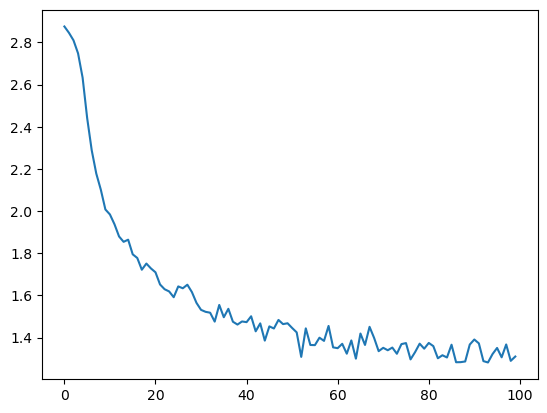

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_246964/2856423273.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_246964/2856423273.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


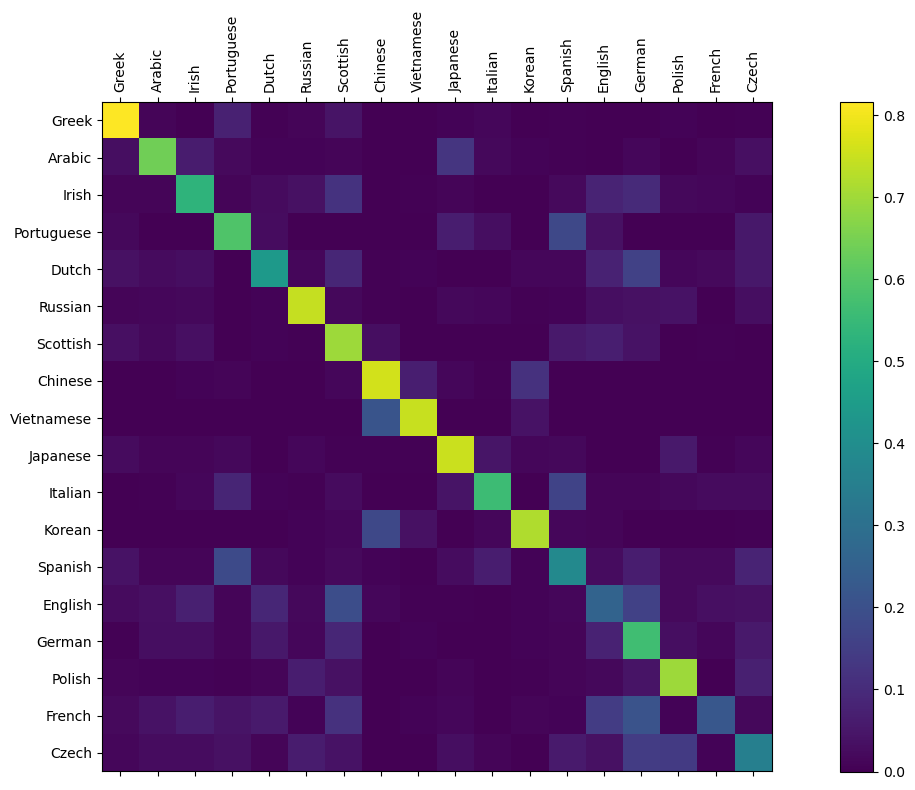

In [26]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor: torch.Tensor) -> torch.Tensor:
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# 随机评估n_confusion个人名，统计各个语种分类的混淆矩阵
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_train_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 归一化混淆矩阵
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 做图
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([""] + all_categories, rotation=90)
ax.set_yticklabels([""] + all_categories)


ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()
plt.show()